In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import math as math
from sklearn.metrics import mean_squared_error
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/project/

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_NLP/project


# Further pre-processing for inventory management

In [2]:
transactions_cleaned = pd.read_pickle("transactions_cleaned.pkl")
transactions_cleaned.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,index_group_name,section_name,month,day_of_week,week_of_year,unique_products
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,29.99,2,Underwear body,Underwear,Solid,Black,Dark,Ladieswear,Womens Lingerie,9,3,38,14
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,17.99,2,Bra,Underwear,Solid,Light Pink,Dusty Light,Ladieswear,Womens Lingerie,9,3,38,14
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,8.99,2,Sweater,Garment Upper body,Melange,Pink,Medium Dusty,Divided,Divided Selected,9,3,38,110
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,9.99,2,Sweater,Garment Upper body,Melange,Pink,Medium,Ladieswear,Womens Everyday Collection,9,3,38,110
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,9.99,2,Sweater,Garment Upper body,Melange,Dark Green,Dark,Ladieswear,Womens Everyday Collection,9,3,38,110


**Function to extract a sales record by datetime for particular item from a particular column**

In [3]:
def sales_extractor (item, group, df, frequency="weekly"):
  df = df.copy()
  frequency_dict = {'monthly':'M', 'weekly':'W'}
  series = df[df[group] == item].groupby(['t_dat'])['customer_id'].count()
  output_df = series.resample(frequency_dict[frequency]).sum().to_frame()
  output_df.rename(mapper={'customer_id':'sales_count'}, axis="columns", inplace=True)
  return output_df

**To identify the top 10 products**

In [5]:
top10product = transactions_cleaned.groupby(['product_type_name'])['article_id'].count().sort_values(ascending=False)
top10product = pd.DataFrame(top10product)
top10product.head(10)

,article_id
product_type_name,
Trousers,4217017
Dress,3238428
Sweater,2783274
T-shirt,2203750
Top,1583408
Blouse,1504868
Vest top,1414101
Bra,1335233
Shorts,1152513


# Jeremy's code

# Vincent's code proof of concept

In [4]:
df = sales_extractor('Sweater', 'product_type_name', transactions_cleaned)
df_train = df.iloc[:-6]
df_test = df.iloc[-6:]

**Using the ARIMA model to predict weekly sales of a particular product**

In [5]:
### Conduct Grid Search for ARIMA ###
def evaluate_arima_model(order, df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()
    model = ARIMA(df_train, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
    error = mean_squared_error(df_test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values, df_train, df_test):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order, df_train, df_test)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [6]:
# specify range of parameters you want to test
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)

# find the best parameters
evaluate_models(p_values, d_values, q_values, df_train, df_test)

ARIMA(0, 0, 0) MSE=107236422.423
ARIMA(0, 0, 1) MSE=84841098.945
ARIMA(0, 0, 2) MSE=80546496.869
ARIMA(0, 1, 0) MSE=388901793.333
ARIMA(0, 1, 1) MSE=402421003.429
ARIMA(0, 1, 2) MSE=402351413.151
ARIMA(0, 2, 0) MSE=232618017.333
ARIMA(0, 2, 1) MSE=381018844.580


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 2) MSE=383374601.571
ARIMA(1, 0, 0) MSE=124383069.174
ARIMA(1, 0, 1) MSE=305727461.606
ARIMA(1, 0, 2) MSE=312628272.574
ARIMA(1, 1, 0) MSE=404751591.147
ARIMA(1, 1, 1) MSE=402402004.358
ARIMA(1, 1, 2) MSE=392310266.209
ARIMA(1, 2, 0) MSE=413673915.835


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 1) MSE=396697605.768
ARIMA(1, 2, 2) MSE=362209698.924
ARIMA(2, 0, 0) MSE=211451005.649
ARIMA(2, 0, 1) MSE=311954663.462


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 2) MSE=123243061.227
ARIMA(2, 1, 0) MSE=398365112.865
ARIMA(2, 1, 1) MSE=397443734.762
ARIMA(2, 1, 2) MSE=394670137.655
ARIMA(2, 2, 0) MSE=423903638.530
ARIMA(2, 2, 1) MSE=398487699.866


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) MSE=406184961.219
Best ARIMA(0, 0, 2) MSE=80546496.869


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
ARIMA_model = ARIMA(df_train, order=(0, 0, 2))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            sales_count   No. Observations:                  100
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1109.864
Date:                Tue, 13 Jun 2023   AIC                           2227.727
Time:                        15:50:03   BIC                           2238.148
Sample:                    09-23-2018   HQIC                          2231.945
                         - 08-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.639e+04   4623.626      5.708      0.000    1.73e+04    3.55e+04
ma.L1          0.5732      0.124      4.632      0.000       0.331       0.816
ma.L2          0.3281      0.105      3.132      0.0

In [8]:
ARIMA_forecast = ARIMA_model_fit.forecast(steps=6)

<Axes: xlabel='t_dat'>

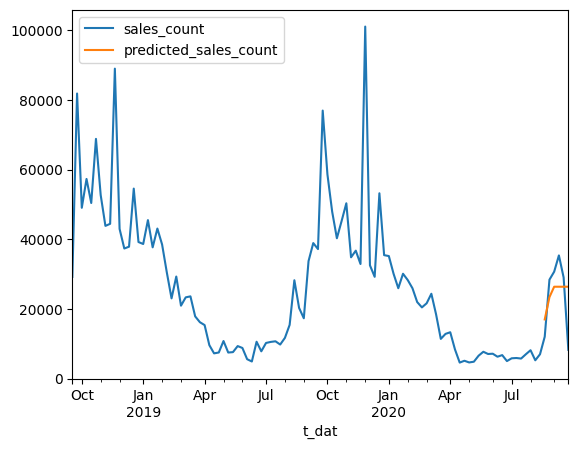

In [9]:
ARIMA_projections = pd.merge(df_test, ARIMA_forecast, left_index=True, right_index=True)
ARIMA_projections.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
pd.concat([df_train, ARIMA_projections], axis=0).plot() #Just plot the concatnated df, showing historical and forecasted

In [12]:
### We use RMSE as an objective measure of the accuracy of the forecast ###
ARIMA_mse = mean_squared_error(df_test, ARIMA_forecast)
ARIMA_rmse = sqrt(ARIMA_mse)
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {ARIMA_rmse}")

The RMSE for the ARIMA model for the projection of 6 weeks is 8974.770017593499


**Next, lets try using the LSTM model to predict sales**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Since LSTMs are sensitive to the scale of input data, we rescale everything between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)

# Transform data to be suitable for LSTM input
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(df_train_scaled, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [ ]:
# Build and train the LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(4, input_shape=(1, look_back)))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

In [ ]:
n_future = 7 #Forecast the next 5 data points
forecast_period_dates = pd.date_range(list(df_train.index)[-1], periods=n_future, freq='W').tolist()

forecast = LSTM_model.predict(trainX[-n_future:]) # forecast

# Perform inverse transformation to rescale back to original range
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'sales_count':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

1/1 [==============================] - 0s 485ms/step


In [ ]:
df_forecast[1:]

,Date,sales_count
1,2020-08-23,6342.298828
2,2020-08-30,6037.364258
3,2020-09-06,5987.191895
4,2020-09-13,5803.742676
5,2020-09-20,6224.002441
6,2020-09-27,6784.600586


In [ ]:
df_test

,sales_count
t_dat,
2020-08-23,12056
2020-08-30,28415
2020-09-06,30709
2020-09-13,35372
2020-09-20,29054
2020-09-27,8298


In [ ]:
### We use RMSE as an objective measure of the accuracy of the forecast ###
LSTM_mse = mean_squared_error(df_test['sales_count'], df_forecast[1:]['sales_count'])
LSTM_rmse = sqrt(LSTM_mse)
print(f"The RMSE for the LSTM model for the projection of 4 weeks is {LSTM_rmse}")

The RMSE for the LSTM model for the projection of 4 weeks is 20584.596854599116


# Application of ARIMA on top 10 product types by sale count

In [ ]:
top10product.head(10)

,article_id
product_type_name,
Trousers,4217017
Dress,3238428
Sweater,2783274
T-shirt,2203750
Top,1583408
Blouse,1504868
Vest top,1414101
Bra,1335233
Shorts,1152513


In [7]:
### Preparing the data points ###
df_trousers = sales_extractor('Trousers', 'product_type_name', transactions_cleaned)
df_train_trousers = df_trousers.iloc[:-6]
df_test_trousers = df_trousers.iloc[-6:]

df_dress = sales_extractor('Dress', 'product_type_name', transactions_cleaned)
df_train_dress = df_dress.iloc[:-6]
df_test_dress = df_dress.iloc[-6:]

df_sweater = sales_extractor('Sweater', 'product_type_name', transactions_cleaned)
df_train_sweater = df_sweater.iloc[:-6]
df_test_sweater = df_sweater.iloc[-6:]

df_T_shirt = sales_extractor('T-shirt', 'product_type_name', transactions_cleaned)
df_train_T_shirt = df_T_shirt.iloc[:-6]
df_test_T_shirt = df_T_shirt.iloc[-6:]

df_Top = sales_extractor('Top', 'product_type_name', transactions_cleaned)
df_train_Top = df_Top.iloc[:-6]
df_test_Top = df_Top.iloc[-6:]

df_Blouse = sales_extractor('Blouse', 'product_type_name', transactions_cleaned)
df_train_Blouse = df_Blouse.iloc[:-6]
df_test_Blouse = df_Blouse.iloc[-6:]

df_Vest_top = sales_extractor('Vest top', 'product_type_name', transactions_cleaned)
df_train_Vest_top = df_Vest_top.iloc[:-6]
df_test_Vest_top = df_Vest_top.iloc[-6:]

df_Bra = sales_extractor('Bra', 'product_type_name', transactions_cleaned)
df_train_Bra = df_Bra.iloc[:-6]
df_test_Bra = df_Bra.iloc[-6:]

df_Shorts = sales_extractor('Shorts', 'product_type_name', transactions_cleaned)
df_train_Shorts = df_Shorts.iloc[:-6]
df_test_Shorts = df_Shorts.iloc[-6:]

df_Bikini_top = sales_extractor('Bikini top', 'product_type_name', transactions_cleaned)
df_train_Bikini_top = df_Bikini_top.iloc[:-6]
df_test_Bikini_top = df_Bikini_top.iloc[-6:]

In [9]:
# find the best parameters
p_values = range(0, 10)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(p_values, d_values, q_values, df_train_Top, df_test_Top)

ARIMA(0, 0, 0) MSE=24816369.771
ARIMA(0, 0, 1) MSE=24607151.974
ARIMA(0, 0, 2) MSE=24936854.644
ARIMA(0, 1, 0) MSE=32239850.333
ARIMA(0, 1, 1) MSE=25104650.749
ARIMA(0, 1, 2) MSE=24634696.524
ARIMA(0, 2, 0) MSE=50023757.500


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 1) MSE=31287922.512
ARIMA(0, 2, 2) MSE=26158996.794
ARIMA(1, 0, 0) MSE=25495574.267
ARIMA(1, 0, 1) MSE=25913318.621
ARIMA(1, 0, 2) MSE=25069486.203
ARIMA(1, 1, 0) MSE=31227047.364
ARIMA(1, 1, 1) MSE=24900827.249
ARIMA(1, 1, 2) MSE=24597137.529
ARIMA(1, 2, 0) MSE=84193245.932
ARIMA(1, 2, 1) MSE=30575581.054


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 2) MSE=26513321.346
ARIMA(2, 0, 0) MSE=26228344.223
ARIMA(2, 0, 1) MSE=25147207.048


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) MSE=25148782.965
ARIMA(2, 1, 0) MSE=28174234.253
ARIMA(2, 1, 1) MSE=24387688.075
ARIMA(2, 1, 2) MSE=24519804.602
ARIMA(2, 2, 0) MSE=76836060.600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 1) MSE=27966845.123
ARIMA(2, 2, 2) MSE=25881164.719
ARIMA(3, 0, 0) MSE=26425445.532
ARIMA(3, 0, 1) MSE=25652951.076
ARIMA(3, 0, 2) MSE=24129936.423
ARIMA(3, 1, 0) MSE=26963883.332
ARIMA(3, 1, 1) MSE=25103161.073
ARIMA(3, 1, 2) MSE=25402691.901
ARIMA(3, 2, 0) MSE=46984810.958
ARIMA(3, 2, 1) MSE=26820771.730
ARIMA(3, 2, 2) MSE=26585286.836
ARIMA(4, 0, 0) MSE=26256803.819
ARIMA(4, 0, 1) MSE=26173771.189
ARIMA(4, 0, 2) MSE=26771410.435
ARIMA(4, 1, 0) MSE=26486246.812
ARIMA(4, 1, 1) MSE=25815175.489


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 1, 2) MSE=25824868.272
ARIMA(4, 2, 0) MSE=39366759.466
ARIMA(4, 2, 1) MSE=26592265.929


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 2) MSE=26143817.458
ARIMA(5, 0, 0) MSE=26118356.290
ARIMA(5, 0, 1) MSE=26193753.845
ARIMA(5, 0, 2) MSE=26405428.832
ARIMA(5, 1, 0) MSE=26690956.459
ARIMA(5, 1, 1) MSE=25854562.744
ARIMA(5, 1, 2) MSE=26060116.196
ARIMA(5, 2, 0) MSE=40560344.241
ARIMA(5, 2, 1) MSE=27026176.419

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARIMA(5, 2, 2) MSE=26302503.062
ARIMA(6, 0, 0) MSE=26905870.066
ARIMA(6, 0, 1) MSE=26971731.282


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(6, 0, 2) MSE=26133960.603
ARIMA(6, 1, 0) MSE=26483768.700
ARIMA(6, 1, 1) MSE=27704797.668


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(6, 1, 2) MSE=31766379.816
ARIMA(6, 2, 0) MSE=46642737.868
ARIMA(6, 2, 1) MSE=26894930.905


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(6, 2, 2) MSE=26388193.393
ARIMA(7, 0, 0) MSE=27027054.393
ARIMA(7, 0, 1) MSE=27087898.084
ARIMA(7, 0, 2) MSE=26301388.407
ARIMA(7, 1, 0) MSE=26955637.129
ARIMA(7, 1, 1) MSE=29143006.779
ARIMA(7, 1, 2) MSE=32642307.707
ARIMA(7, 2, 0) MSE=56122403.214


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(7, 2, 1) MSE=27409507.179


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(7, 2, 2) MSE=42092987.797
ARIMA(8, 0, 0) MSE=27146452.609
ARIMA(8, 0, 1) MSE=26932688.267
ARIMA(8, 0, 2) MSE=27133480.139
ARIMA(8, 1, 0) MSE=28030076.554
ARIMA(8, 1, 1) MSE=29298541.543


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(8, 1, 2) MSE=29581090.266
ARIMA(8, 2, 0) MSE=53172828.015
ARIMA(8, 2, 1) MSE=29394251.590


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(8, 2, 2) MSE=29305587.825
ARIMA(9, 0, 0) MSE=26678061.517
ARIMA(9, 0, 1) MSE=27096811.090


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(9, 0, 2) MSE=26511355.817
ARIMA(9, 1, 0) MSE=28028510.075
ARIMA(9, 1, 1) MSE=29310152.210


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(9, 1, 2) MSE=29554411.346
ARIMA(9, 2, 0) MSE=50553694.422


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(9, 2, 1) MSE=29386970.664


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(9, 2, 2) MSE=29370029.102
Best ARIMA(3, 0, 2) MSE=24129936.423


In [10]:
### Training the models ###
ARIMA_model_trousers = ARIMA(df_train_trousers, order=(2, 1, 1))
ARIMA_model_fit_trousters = ARIMA_model_trousers.fit()

ARIMA_model_dress = ARIMA(df_train_dress, order=(1, 2, 0))
ARIMA_model_fit_dress = ARIMA_model_dress.fit()

ARIMA_model_sweater = ARIMA(df_train_sweater, order=(0, 0, 2))
ARIMA_model_fit_sweater = ARIMA_model_sweater.fit()

ARIMA_model_T_shirt = ARIMA(df_train_T_shirt, order=(2, 2, 0))
ARIMA_model_fit_T_shirt = ARIMA_model_T_shirt.fit()

ARIMA_model_Top = ARIMA(df_train_Top, order=(3, 0, 2))
ARIMA_model_fit_Top = ARIMA_model_Top.fit()

ARIMA_model_Blouse = ARIMA(df_train_Blouse, order=(2, 2, 0))
ARIMA_model_fit_Blouse = ARIMA_model_Blouse.fit()

ARIMA_model_Vest_top = ARIMA(df_train_Vest_top, order=(0, 2, 0))
ARIMA_model_fit_Vest_top = ARIMA_model_Vest_top.fit()

ARIMA_model_Bra = ARIMA(df_train_Bra, order=(2, 2, 0))
ARIMA_model_fit_Bra = ARIMA_model_Bra.fit()

ARIMA_model_Shorts = ARIMA(df_train_Shorts, order=(1, 2, 0))
ARIMA_model_fit_Shorts = ARIMA_model_Shorts.fit()

ARIMA_model_Bikini_top = ARIMA(df_train_Bikini_top, order=(6, 2, 2))
ARIMA_model_fit_Bikini_top = ARIMA_model_Bikini_top.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The RMSE for the ARIMA model for the projection of 6 weeks is 12363.2436635647


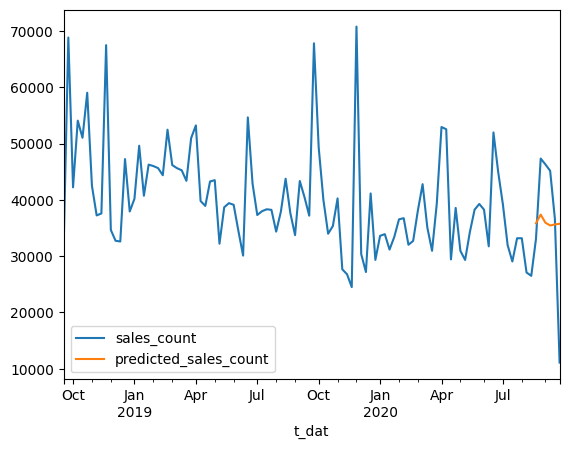

In [11]:
ARIMA_forecast_trousers = ARIMA_model_fit_trousters.forecast(steps=6)
ARIMA_projections_trousers = pd.merge(df_test_trousers, ARIMA_forecast_trousers, left_index=True, right_index=True)
ARIMA_projections_trousers.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
trousers_output_df = pd.concat([df_train_trousers, ARIMA_projections_trousers], axis=0)
trousers_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_trousers, ARIMA_forecast_trousers))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 6052.644878320047


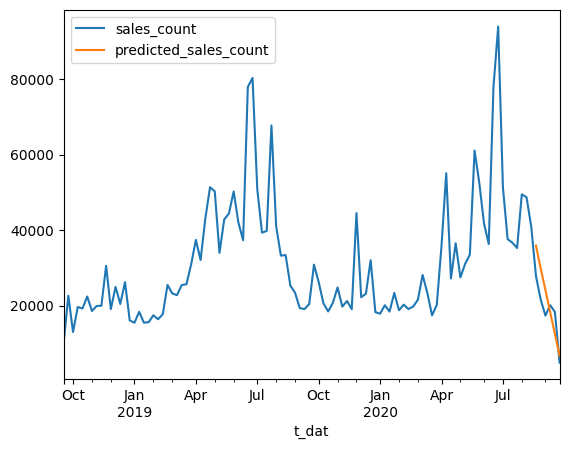

In [12]:
ARIMA_forecast_dress = ARIMA_model_fit_dress.forecast(steps=6)
ARIMA_projections_dress = pd.merge(df_test_dress, ARIMA_forecast_dress, left_index=True, right_index=True)
ARIMA_projections_dress.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
dress_output_df = pd.concat([df_train_dress, ARIMA_projections_dress], axis=0)
dress_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_dress, ARIMA_forecast_dress))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 8974.770017593499


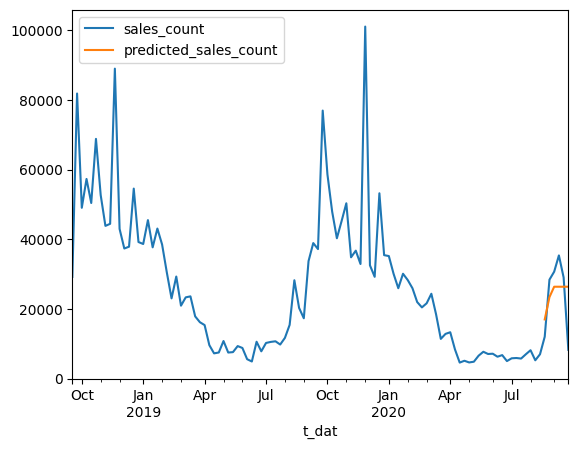

In [13]:
ARIMA_forecast_sweater = ARIMA_model_fit_sweater.forecast(steps=6)
ARIMA_projections_sweater = pd.merge(df_test_sweater, ARIMA_forecast_sweater, left_index=True, right_index=True)
ARIMA_projections_sweater.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
sweater_output_df = pd.concat([df_train_sweater, ARIMA_projections_sweater], axis=0)
sweater_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_sweater, ARIMA_forecast_sweater))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 2789.380372096141


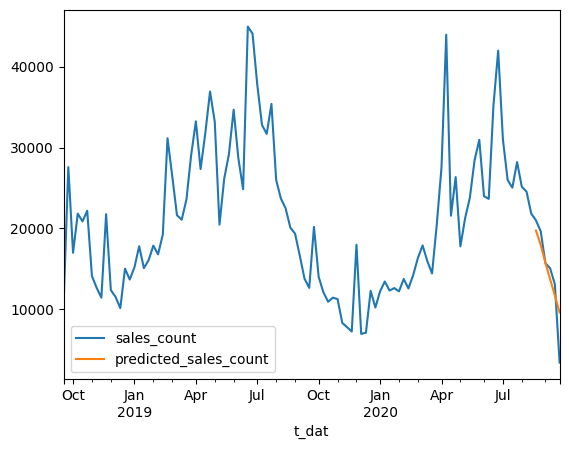

In [14]:
ARIMA_forecast_T_shirt = ARIMA_model_fit_T_shirt.forecast(steps=6)
ARIMA_projections_T_shirt = pd.merge(df_test_T_shirt, ARIMA_forecast_T_shirt, left_index=True, right_index=True)
ARIMA_projections_T_shirt.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
T_shirt_output_df = pd.concat([df_train_T_shirt, ARIMA_projections_T_shirt], axis=0)
T_shirt_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_T_shirt, ARIMA_forecast_T_shirt))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 4912.223165057095


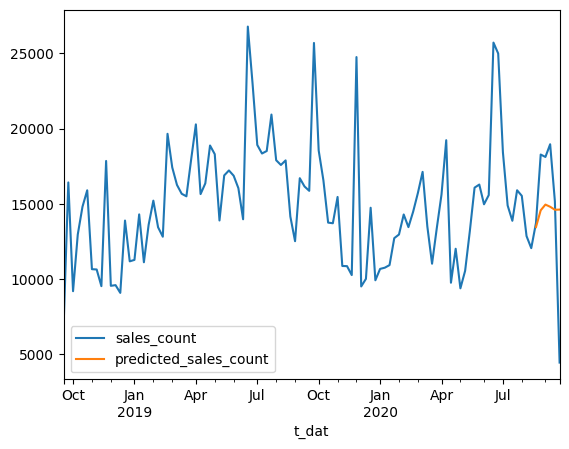

In [15]:
ARIMA_forecast_Top = ARIMA_model_fit_Top.forecast(steps=6)
ARIMA_projections_Top = pd.merge(df_test_Top, ARIMA_forecast_Top, left_index=True, right_index=True)
ARIMA_projections_Top.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
Top_output_df = pd.concat([df_train_Top, ARIMA_projections_Top], axis=0)
Top_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_Top, ARIMA_forecast_Top))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 2559.0232462865292


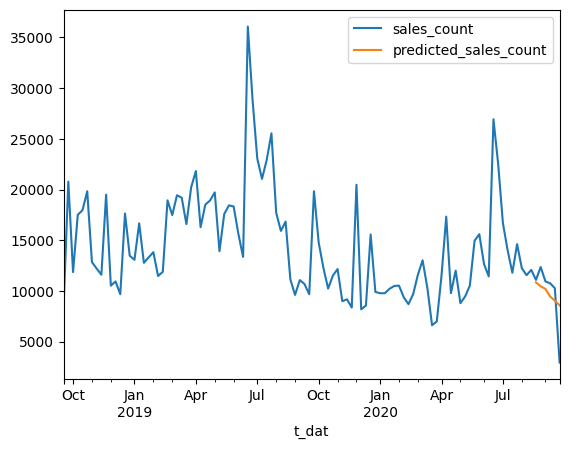

In [16]:
ARIMA_forecast_Blouse = ARIMA_model_fit_Blouse.forecast(steps=6)
ARIMA_projections_Blouse = pd.merge(df_test_Blouse, ARIMA_forecast_Blouse, left_index=True, right_index=True)
ARIMA_projections_Blouse.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
Blouse_output_df = pd.concat([df_train_Blouse, ARIMA_projections_Blouse], axis=0)
Blouse_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_Blouse, ARIMA_forecast_Blouse))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 4843.597509427615


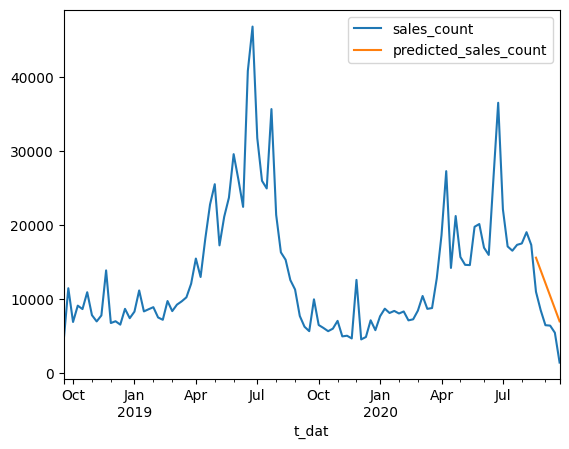

In [17]:
ARIMA_forecast_Vest_top = ARIMA_model_fit_Vest_top.forecast(steps=6)
ARIMA_projections_Vest_top = pd.merge(df_test_Vest_top, ARIMA_forecast_Vest_top, left_index=True, right_index=True)
ARIMA_projections_Vest_top.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
Vest_top_output_df = pd.concat([df_train_Vest_top, ARIMA_projections_Vest_top], axis=0)
Vest_top_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_Vest_top, ARIMA_forecast_Vest_top))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 3113.5569960127605


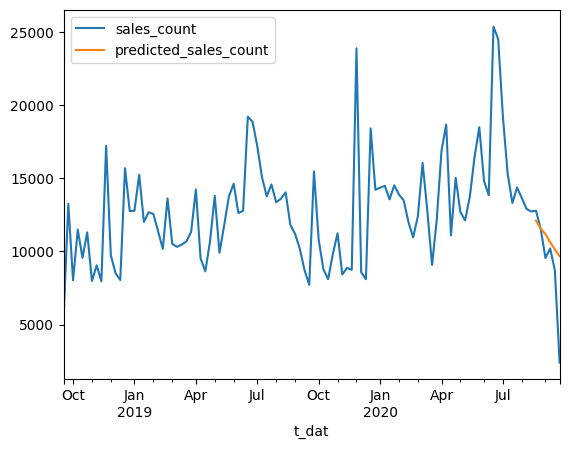

In [18]:
ARIMA_forecast_Bra = ARIMA_model_fit_Bra.forecast(steps=6)
ARIMA_projections_Bra = pd.merge(df_test_Bra, ARIMA_forecast_Bra, left_index=True, right_index=True)
ARIMA_projections_Bra.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
Bra_output_df = pd.concat([df_train_Bra, ARIMA_projections_Bra], axis=0)
Bra_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_Bra, ARIMA_forecast_Bra))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 3933.6922120169306


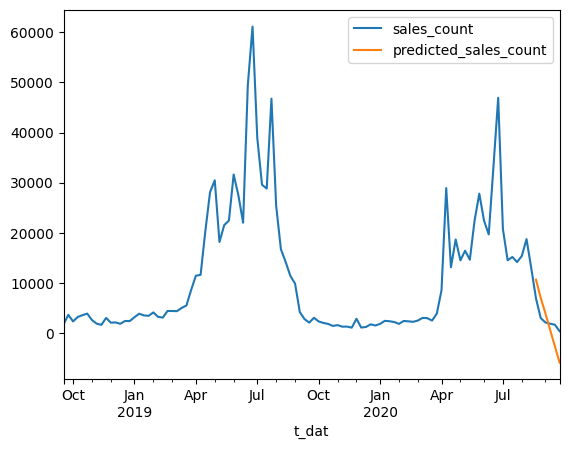

In [19]:
ARIMA_forecast_Shorts = ARIMA_model_fit_Shorts.forecast(steps=6)
ARIMA_projections_Shorts = pd.merge(df_test_Shorts, ARIMA_forecast_Shorts, left_index=True, right_index=True)
ARIMA_projections_Shorts.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
Shorts_output_df = pd.concat([df_train_Shorts, ARIMA_projections_Shorts], axis=0)
Shorts_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_Shorts, ARIMA_forecast_Shorts))}")

The RMSE for the ARIMA model for the projection of 6 weeks is 6759.750023094086


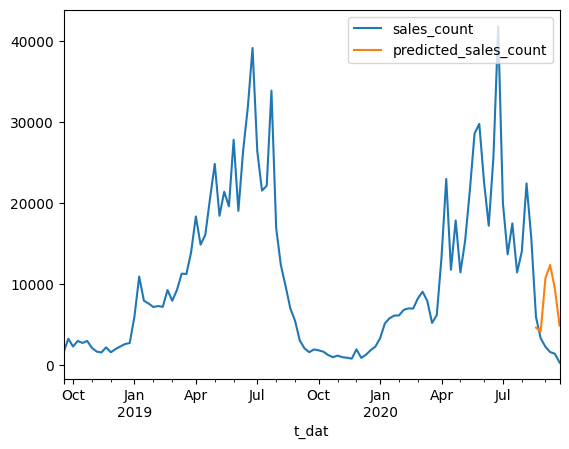

In [20]:
ARIMA_forecast_Bikini_top = ARIMA_model_fit_Bikini_top.forecast(steps=6)
ARIMA_projections_Bikini_top = pd.merge(df_test_Bikini_top, ARIMA_forecast_Bikini_top, left_index=True, right_index=True)
ARIMA_projections_Bikini_top.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
Bikini_top_output_df = pd.concat([df_train_Bikini_top, ARIMA_projections_Bikini_top], axis=0)
Bikini_top_output_df.plot()
print(f"The RMSE for the ARIMA model for the projection of 6 weeks is {sqrt(mean_squared_error(df_test_Bikini_top, ARIMA_forecast_Bikini_top))}")

**Aggregated plot of inventory management**

In [21]:
import matplotlib.pyplot as plt

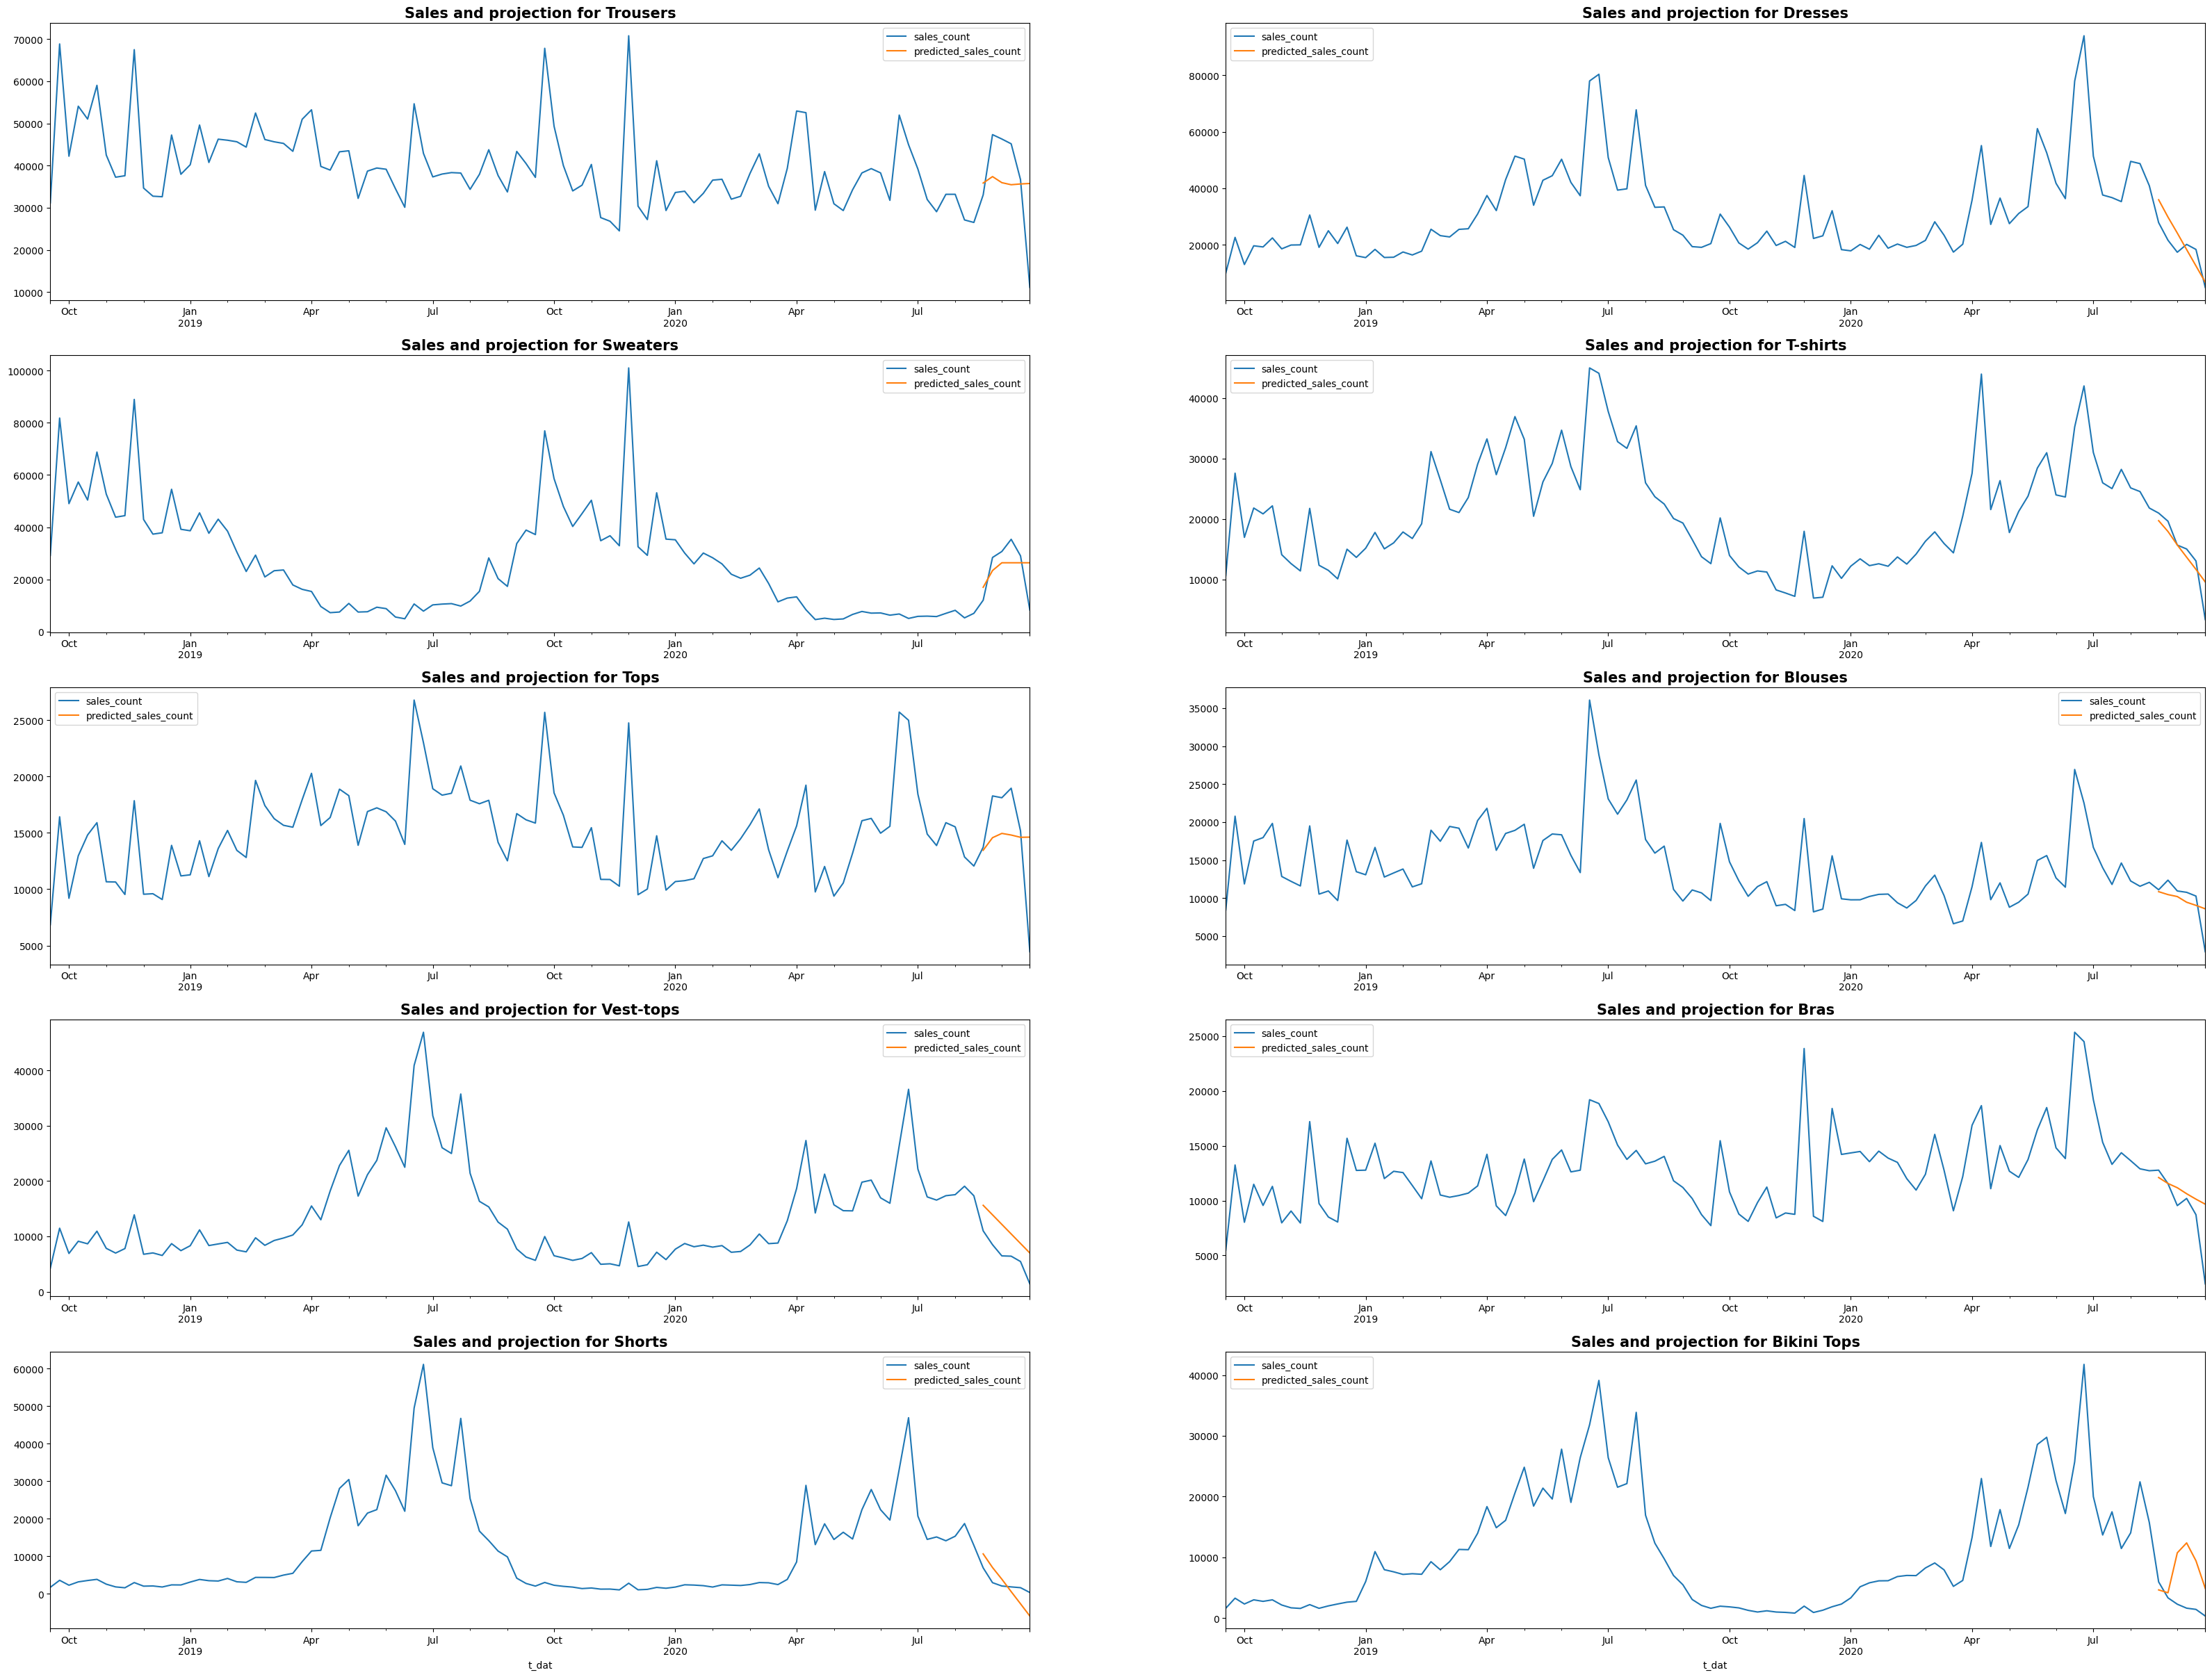

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(40,30))

trousers_output_df.plot(ax=axes[0,0])
axes[0,0].set_title('Sales and projection for Trousers', fontweight='bold', size=15)
dress_output_df.plot(ax=axes[0,1])
axes[0,1].set_title('Sales and projection for Dresses', fontweight='bold', size=15)

sweater_output_df.plot(ax=axes[1,0])
axes[1,0].set_title('Sales and projection for Sweaters', fontweight='bold', size=15)
T_shirt_output_df.plot(ax=axes[1,1])
axes[1,1].set_title('Sales and projection for T-shirts', fontweight='bold', size=15)

Top_output_df.plot(ax=axes[2,0])
axes[2,0].set_title('Sales and projection for Tops', fontweight='bold', size=15)
Blouse_output_df.plot(ax=axes[2,1])
axes[2,1].set_title('Sales and projection for Blouses', fontweight='bold', size=15)

Vest_top_output_df.plot(ax=axes[3,0])
axes[3,0].set_title('Sales and projection for Vest-tops', fontweight='bold', size=15)
Bra_output_df.plot(ax=axes[3,1])
axes[3,1].set_title('Sales and projection for Bras', fontweight='bold', size=15)

Shorts_output_df.plot(ax=axes[4,0])
axes[4,0].set_title('Sales and projection for Shorts', fontweight='bold', size=15)
Bikini_top_output_df.plot(ax=axes[4,1])
axes[4,1].set_title('Sales and projection for Bikini Tops', fontweight='bold', size=15)

for n in range (4):
  axes[n,0].set_xlabel(None)
  axes[n,1].set_xlabel(None)

plt.show()

In [43]:
rmse_list = [round(sqrt(mean_squared_error(df_test_trousers, ARIMA_forecast_trousers)),3),
 round(sqrt(mean_squared_error(df_test_dress, ARIMA_forecast_dress)),3),
 round(sqrt(mean_squared_error(df_test_sweater, ARIMA_forecast_sweater)),3),
 round(sqrt(mean_squared_error(df_test_T_shirt, ARIMA_forecast_T_shirt)),3),
 round(sqrt(mean_squared_error(df_test_Top, ARIMA_forecast_Top)),3),
 round(sqrt(mean_squared_error(df_test_Blouse, ARIMA_forecast_Blouse)),3),
 round(sqrt(mean_squared_error(df_test_Vest_top, ARIMA_forecast_Vest_top)),3),
 round(sqrt(mean_squared_error(df_test_Bra, ARIMA_forecast_Bra)),3),
 round(sqrt(mean_squared_error(df_test_Shorts, ARIMA_forecast_Shorts)),3),
 round(sqrt(mean_squared_error(df_test_Bikini_top, ARIMA_forecast_Bikini_top)),3)]

average_list = [round(df_test_trousers.mean().item(),3),
                round(df_test_dress.mean().item(),3),
                round(df_test_sweater.mean().item(),3),
                round(df_test_T_shirt.mean().item(),3),
                round(df_test_Top.mean().item(),3),
                round(df_test_Blouse.mean().item(),3),
                round(df_test_Vest_top.mean().item(),3),
                round(df_test_Bra.mean().item(),3),
                round(df_test_Shorts.mean().item(),3),
                round(df_test_Bikini_top.mean().item(),3)]

In [47]:
ARIMA_forecast_Shorts.mean()

2272.4067416244848

In [46]:
df = pd.DataFrame(rmse_list, columns=['RMSE'])
df['Avg. sales count'] = average_list
df['RSME/Sales count'] = df['RMSE'] / df['Avg. sales count']
df

,RMSE,Avg. sales count,RSME/Sales count
0,12363.244,36604.000,0.337757
1,6052.645,18336.833,0.330081
2,8974.770,23984.000,0.374198
3,2789.380,14646.833,0.190443
4,4912.223,14786.333,0.332214
5,2559.023,9733.000,0.262922
6,4843.598,6534.333,0.741254
7,3113.557,9202.000,0.338357
8,3933.692,2646.833,1.486188
9,6759.750,2491.333,2.713306
